In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
from scipy import interpolate
from scipy.interpolate import Rbf
import seawater as sw
from seawater.library import T90conv
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import h5py

In [2]:
depth=[5,10,20,30,50,75,100,125,150,200,250,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000]

In [ ]:
Argo_0 = nc.Dataset('../数据/ARGO/argo 05-20 0.nc')
for i in depth:
    locals()['Argo_'+str(i)] = nc.Dataset('../数据/ARGO/argo 05-20 '+str(i)+'.nc')
    Argo_i = locals()['Argo_'+str(i)]

In [4]:
a = Argo_0.variables['salt'][:,:,:,:]        #60:120,30:120
a.shape

(192, 1, 180, 360)

In [5]:
Argo_temp_0 = Argo_0.variables['temp'][:,:,60:120,30:120]
Argo_salt_0 = Argo_0.variables['salt'][:,:,60:120,30:120]
Argo_temp_0.shape

(192, 1, 60, 90)

In [6]:
lons=Argo_0.variables['longitude'][:]
lats=Argo_0.variables['latitude'][:]

In [7]:
for i in depth:
    Argo_i = locals()['Argo_'+str(i)]
    locals()['Argo_temp_'+str(i)] = Argo_i.variables['temp'][:,:,60:120,30:120]
    Argo_temp_i = locals()['Argo_temp_'+str(i)]

In [8]:
for i in depth:
    Argo_i = locals()['Argo_'+str(i)]
    locals()['Argo_salt_'+str(i)] = Argo_i.variables['salt'][:,:,60:120,30:120]
    Argo_salt_i = locals()['Argo_salt_'+str(i)]

In [9]:
a = np.zeros((Argo_temp_0.shape[0],Argo_temp_0.shape[1],Argo_temp_0.shape[2],Argo_temp_0.shape[3]))
for i in depth:
    Argo_temp_i = locals()['Argo_temp_'+str(i)]
    locals()['temp_'+str(i)] = np.where(Argo_temp_i < -900, np.full_like(Argo_temp_i,None), Argo_temp_i)
    temp_i = locals()['temp_'+str(i)]
    Argo_temp = np.concatenate((a,temp_i),1)
    a = Argo_temp

In [10]:
a = np.zeros((Argo_salt_0.shape[0],Argo_salt_0.shape[1],Argo_salt_0.shape[2],Argo_salt_0.shape[3]))
for i in depth:
    Argo_salt_i = locals()['Argo_salt_'+str(i)]
    locals()['salt_'+str(i)] = np.where(Argo_salt_i < -900, np.full_like(Argo_salt_i,None), Argo_salt_i)
    salt_i = locals()['salt_'+str(i)]
    Argo_salt = np.concatenate((a,salt_i),1)
    a = Argo_salt

In [11]:
Argo_temp.shape

(192, 27, 60, 90)

In [12]:
IO_temp_surface = Argo_temp_0[12*7:,0,:,:]
IO_salt_surface = Argo_salt_0[12*7:,0,:,:]
IO_temp_surface.shape

(108, 60, 90)

In [13]:
IO_temp_unsurface = Argo_temp[12*7:,1:,:,:]
IO_salt_unsurface = Argo_salt[12*7:,1:,:,:]
IO_temp_unsurface.shape

(108, 26, 60, 90)

In [14]:
#计算表面密度
pden_0 = np.zeros((IO_salt_surface.shape[0],IO_salt_surface.shape[1],IO_salt_surface.shape[2]))
for i in range(IO_salt_surface.shape[0]):                    #时间
    for j in range(IO_salt_surface.shape[1]):                #纬度
        for k in range(IO_salt_surface.shape[2]):            #经度
            pden_0[i,j,k]=sw.pden(IO_salt_surface[i,j,k], T90conv(IO_temp_surface[i,j,k]),1000)
pden_0.shape

(108, 60, 90)

In [16]:
#计算非表面密度
depth = [5,10,20,30,50,75,100,125,150,200,250,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000]
IO_lat = lats[60:120]
pden_depth=np.zeros((IO_salt_unsurface.shape[0],IO_salt_unsurface.shape[1],IO_salt_unsurface.shape[2],IO_salt_unsurface.shape[3]))
for i in range(IO_salt_unsurface.shape[0]):                  #时间
    for j in range(IO_salt_unsurface.shape[1]):              #深度
        deep = depth[j]
        for k in range(IO_salt_unsurface.shape[2]):          #纬度
            lat=IO_lat[k]
            for l in range(IO_salt_unsurface.shape[3]):      #经度
                p=sw.pres(deep,lat)
                pden_depth[i,j,k,l]=sw.pden(IO_salt_unsurface[i,j,k,l],T90conv(IO_temp_unsurface[i,j,k,l]),p,1000)#每一点的密度
pden_depth.shape

(108, 26, 60, 90)

In [17]:
IO_temp_surface = np.where(IO_temp_surface < -900, np.full_like(IO_temp_surface,None), IO_temp_surface)
IO_temp_surface = np.where(IO_temp_surface < -900, np.full_like(IO_temp_surface,None), IO_temp_surface)

In [18]:
#所有变量的全部值
IO_temp_surface = IO_temp_surface.reshape(108,1,60,90)
IO_temp_all = np.concatenate((IO_temp_surface,IO_temp_unsurface),1)
IO_salt_surface = IO_salt_surface.reshape(108,1,60,90)
IO_salt_all = np.concatenate((IO_salt_surface,IO_salt_unsurface),1)
pden_0 = pden_0.reshape(108,1,60,90)
pden_all = np.concatenate((pden_0,pden_depth),1)
depth_all = [0,5,10,20,30,50,75,100,125,150,200,250,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000]

In [19]:
IO_temp_all.shape

(108, 27, 60, 90)

In [21]:
#计算ILD
from scipy import interpolate
ILD = np.zeros((pden_all.shape[0],pden_all.shape[2],pden_all.shape[3]))
for i in range(pden_all.shape[0]):
    print(i)
    for k in range(pden_all.shape[2]):
        for l in range(pden_all.shape[3]):
            for j in range(26):
                if np.isnan(IO_temp_all[i,j,k,l])==False:
                    if IO_temp_all[i,0,k,l]-IO_temp_all[i,j,k,l]<0.5 and IO_temp_all[i,0,k,l]-IO_temp_all[i,j+1,k,l]>=0.5:
                        x = depth_all
                        y = IO_temp_all[i,:,k,l]
                        xnew = np.linspace(depth_all[j],depth_all[j+1],100)
                        f=interpolate.interp1d(x,y,kind='slinear')
                        t_temp=f(xnew)
                        for j_c in range(len(t_temp)-1):
                            if IO_temp_all[i,0,k,l]-t_temp[j_c]<0.5 and IO_temp_all[i,0,k,l]-t_temp[j_c+1]>=0.5:
                                ILD[i,k,l]= xnew[j_c]
                else:
                    ILD[i,k,l]=np.nan
ILD.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


(108, 60, 90)

In [22]:
ILD

array([[[        nan,         nan, 24.34343434, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan, 32.02020202, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [25]:
#计算MLD
MLD = np.zeros((pden_all.shape[0],pden_all.shape[2],pden_all.shape[3]))
for i in range(pden_all.shape[0]):
    print(i)
    for k in range(pden_all.shape[2]):
        lat = IO_lat[k]
        for l in range(pden_all.shape[3]):
            for j in range(26):                        
                if np.isnan(pden_all[i,j,k,l]) == False:
                    p0=sw.pres(0,lat)
                    diff=sw.pden(IO_salt_all[i,0,k,l],T90conv(IO_temp_all[i,0,k,l]-0.5),p0,1000)-pden_all[i,0,k,l]
                    if pden_all[i,j,k,l] - pden_all[i,0,k,l] < diff and pden_all[i,j+1,k,l] - pden_all[i,0,k,l] >= diff:
                        x = depth_all
                        y_temp = IO_temp_all[i,:,k,l]
                        y_salt = IO_salt_all[i,:,k,l]
                        xnew = np.linspace(depth_all[j],depth_all[j+1],100)
                        f_temp=interpolate.interp1d(x,y_temp,kind='slinear')
                        f_salt=interpolate.interp1d(x,y_salt,kind='slinear')
                        chazhi_temp=f_temp(xnew)
                        chazhi_salt = f_salt(xnew)
                        for j_c in range(len(chazhi_temp)-1):
                            deep=xnew[j_c]
                            deep_1 = xnew[j_c+1]
                            p = sw.pres(deep,lat)
                            p_1 = sw.pres(deep_1,lat)
                            chazhi_pden = sw.pden(chazhi_salt[j_c],T90conv(chazhi_temp[j_c]),p,1000)
                            chazhi_pden_1 = sw.pden(chazhi_salt[j_c+1], T90conv(chazhi_temp[j_c+1]),p_1,1000)
                            if chazhi_pden - pden_all[i,0,k,l] < diff and chazhi_pden_1 - pden_all[i,0,k,l] >= diff:
                                MLD[i,k,l] = xnew[j_c+1]
                else:
                    MLD[i,k,l]=np.nan
MLD.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


(108, 60, 90)

In [26]:
MLD

array([[[        nan,         nan, 24.94949495, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan, 30.        , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [27]:
#计算BLT
BLT = ILD[:,:,:] - MLD[:,:,:]
BLT.shape

(108, 60, 90)

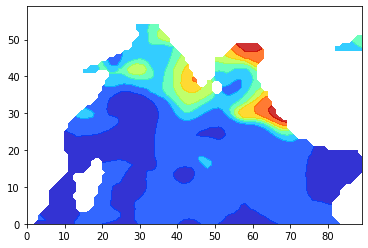

In [29]:
cf = plt.contourf(BLT[0,:,:], alpha=0.8, cmap='jet')

In [33]:
#保存为npy文件
from numpy import save
save('data.npy',BLT)

In [2]:
#读取npy文件
from numpy import load
BLT = load('data.npy')
BLT

array([[[        nan,         nan, -0.60606061, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,  2.02020202, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [3]:
BLT.shape

(108, 60, 90)

In [22]:
BLT_2012 = BLT[0*12:1*12,:,:]
BLT_2012.shape

(12, 60, 90)

In [23]:
BLT_2012 = pd.DataFrame(np.nanmean(BLT[0*12:1*12,:,:],0))
BLT_2012 = BLT_2012.fillna(999)
BLT_2012 = np.array(BLT_2012)

In [24]:
BLT_2012 = np.where(BLT_2012 < 0, np.full_like(BLT_2012,0), BLT_2012)
BLT_2012 = np.where(BLT_2012 > 900, np.full_like(BLT_2012,None), BLT_2012)

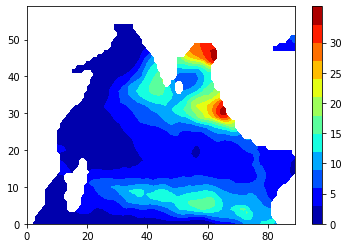

In [25]:
plt.contourf(BLT_2012,levels=12,cmap=plt.get_cmap('jet'))
cbar = plt.colorbar()
cbar.set_ticks([0,5,10,15,20,25,30])

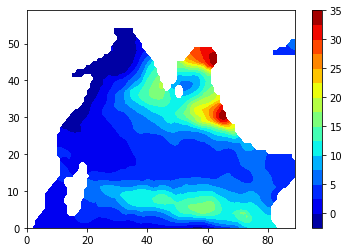

In [5]:
plt.contourf(np.nanmean(BLT[0*12:1*12,:,:],0),levels=15,cmap=plt.get_cmap('jet'))
plt.colorbar()